Reference : https://www.kaggle.com/muonneutrino/sentiment-analysis-with-amazon-reviews

In [6]:
import warnings
warnings.filterwarnings('ignore')
# eval_metric
import sys
sys.path.insert(0,'..')

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras import models, layers, optimizers
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
import bz2
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
import re

%matplotlib inline

In [25]:
import os
base = "../data/amazon_reviews"

In [26]:
from common.util import get_labels_and_texts

In [10]:
train_labels, train_texts = get_labels_and_texts(base + '/train.ft.txt')
test_labels, test_texts = get_labels_and_texts(base + '/test.ft.txt')

In [11]:
train_labels[0:2]

array([1, 1])

In [12]:
train_texts[0:1]

['Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^']

## Text Preprocessing
The first thing we are to do to process the text is to lowercase everything and then remove non-word characters. Replace these with spaces since most are going to be punctuation. Then remove any other characters (like letters with accents). It could be better to replace some of these with regular ascii characters but we are going to ignore that here. It also turns out if you look at the counts of the different characters that there are very few unusual characters in this corpus.

In [18]:
from common.util import normalize_texts
        
train_texts = normalize_texts(train_texts)
test_texts = normalize_texts(test_texts)

## Train/Validation Split
Now We are going to set aside 20% of the training set for validation.

In [19]:
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, random_state=57643892, test_size=0.2)

Keras provides some tools for converting text to formats that are useful in deep learning models. We have already done some processing, so now I will just run a Tokenizer using the top 12000 words as features.

In [20]:
MAX_FEATURES = 12000
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(train_texts)
train_texts = tokenizer.texts_to_sequences(train_texts)
val_texts = tokenizer.texts_to_sequences(val_texts)
test_texts = tokenizer.texts_to_sequences(test_texts)

In order to use batches effectively, We are going to need to take my sequences and turn them into sequences of the same length. We are going to make everything here the length of the longest sentence in the training set. There are also different padding modes that might be useful for different models.

In [21]:
MAX_LENGTH = max(len(train_ex) for train_ex in train_texts)
train_texts = pad_sequences(train_texts, maxlen=MAX_LENGTH)
val_texts = pad_sequences(val_texts, maxlen=MAX_LENGTH)
test_texts = pad_sequences(test_texts, maxlen=MAX_LENGTH)

In [22]:
#SimpleRNN(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True)
#from tensorflow.keras.layers import SimpleRNN
def build_rnn_model():
    sequences = layers.Input(shape=(MAX_LENGTH,))
    embedded = layers.Embedding(MAX_FEATURES, 64)(sequences)
    #x = layers.CuDNNGRU(128, return_sequences=True)(embedded)
    #x = layers.CuDNNGRU(128)(x)
    x = layers.SimpleRNN(128)(embedded)
    #x = layers.GRU(128, return_sequences=True)(embedded)
    #x = layers.GRU(128)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(100, activation='relu')(x)
    predictions = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=sequences, outputs=predictions)
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['binary_accuracy']
    )
    return model
    
rnn_model = build_rnn_model()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [23]:
 tensorflow.test.is_gpu_available

<function tensorflow.python.framework.test_util.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)>

In [24]:
history = rnn_model.fit(
    train_texts, 
    train_labels, 
    batch_size=128,
    epochs=10,
    validation_data=(val_texts, val_labels), )

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 18s 2ms/sample - loss: 0.6958 - binary_accuracy: 0.4996 - val_loss: 0.6942 - val_binary_accuracy: 0.5120
Epoch 2/10
8000/8000 [==============================] - 18s 2ms/sample - loss: 0.6927 - binary_accuracy: 0.5095 - val_loss: 0.7219 - val_binary_accuracy: 0.5120
Epoch 3/10
8000/8000 [==============================] - 18s 2ms/sample - loss: 0.6413 - binary_accuracy: 0.6194 - val_loss: 0.5759 - val_binary_accuracy: 0.6970
Epoch 4/10
8000/8000 [==============================] - 18s 2ms/sample - loss: 0.4587 - binary_accuracy: 0.7925 - val_loss: 0.4501 - val_binary_accuracy: 0.7905
Epoch 5/10
8000/8000 [==============================] - 17s 2ms/sample - loss: 0.3601 - binary_accuracy: 0.8472 - val_loss: 0.4337 - val_binary_accuracy: 0.8110
Epoch 6/10
8000/8000 [==============================] - 17s 2ms/sample - loss: 0.2982 - binary_accuracy: 0.8786 - val_loss: 0.4680 - val_binary_acc

In [27]:
from common.plot_util import eval_metric

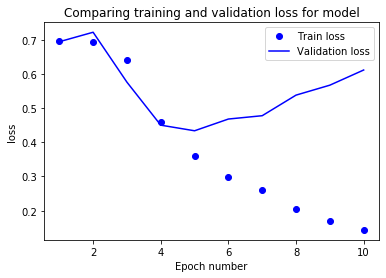

In [28]:
eval_metric(rnn_model, history, 'loss', 10)

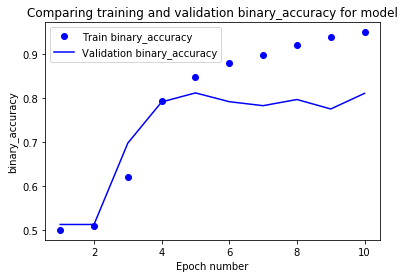

In [29]:
eval_metric(rnn_model, history, 'binary_accuracy', 10)